<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 5 | Notebook 4: Modeling

### Carly Sharma, Jake Parker, & Adam Zucker

**CONTENTS:**
- Classification models based on our master dataframe, `true_df.csv`, and dummified master dataframe, `dummy_df.csv`. Models run:
    - Logistic Regression
    - $k$ Nearest Neighbors
    - Random Forest Classifier
    - Support Vector Classification
    - Convolutional Neural Network
<br>
<br>
- Data in our master dataframe was sourced from:
    - [Kaggle's](https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020?select=California_Fire_Incidents.csv) California Wildfire Incidents dataset
    - [NOAA](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00946/html) Meteorological data
    - Atmospheric carbon data collected by [NOAA/Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/dv/data/index.php?parameter_name=Carbon%2BDioxide&search=mauna+loa))

**BELOW:** Package and data imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC

from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [2]:
df = pd.read_csv('../data_clean/true_df.csv')
dummy_df = pd.read_csv('../data_clean/dummy_df.csv')

In [3]:
# Dropping unnecessary features from the master df
df = df.drop(columns=['highest_daily_snowfall', 'cooling_degree_days', 'admin_unit', 
                      'fire_name', 'extinguished', 'qc_flag'])

In [4]:
df.isnull().sum()

date                           0
county                         0
latitude                       0
longitude                      0
acres_burned                   0
fire_bins                      0
duration                       0
started                        0
major_incident                 0
avg_wind_speed                 0
avg_monthly_temp               0
extreme_max_temp               0
extreme_min_temp               0
total_monthly_precipitation    0
total_monthly_snowfall         0
dsnd                           0
dp10                           0
dt00                           0
dt32                           0
dx32                           0
dx70                           0
elevation                      0
co2_measured_mole_fraction     0
temp_range                     0
month                          0
season                         0
dtype: int64

In [5]:
dummy_df.dtypes.value_counts()

int64      69
float64    19
object      1
dtype: int64

---

In [6]:
# Defining X and y
X = dummy_df.drop(columns=['date', 'fire_bins'])
y = dummy_df['fire_bins']

# Instantiating a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

# Scaling data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

**Baseline accuracy:**

In [7]:
y.value_counts(normalize=True)

1    0.389195
6    0.164278
3    0.160970
2    0.155458
4    0.078280
5    0.051819
Name: fire_bins, dtype: float64

### Logistic Regression

In [8]:
#Log Reggresion 
log = LogisticRegression(max_iter=5000)

log_params = {
    'fit_intercept': [True, False],
    'C': [1, 0.5, 0.1]
}

logistic_model_gridsearch = GridSearchCV(log, log_params, cv = 5, n_jobs=8)

# Fitting to unscaled data and evaluating performance
logistic_model_gridsearch.fit(X_train, y_train)

print('Logistic Regression Evaluation with Unscaled Data:')
print(f'Best Parameters         = {logistic_model_gridsearch.best_params_}')
print(f'Best Estimator          = {logistic_model_gridsearch.best_estimator_}')
print(f'Best Cross-Value Score  = {logistic_model_gridsearch.best_score_}')
print(f'Training R-Squared      = {logistic_model_gridsearch.score(X_train,y_train)}')
print(f'Testing R-Squared       = {logistic_model_gridsearch.score(X_test,y_test)}')

# Fitting to scaled data and evaluating performance
logistic_model_gridsearch.fit(X_train_sc, y_train)

print('------------------------------------------------------------')
print('Logistic Regression Evaluation with Scaled Data:')
print(f'Best Parameters         = {logistic_model_gridsearch.best_params_}')
print(f'Best Estimator          = {logistic_model_gridsearch.best_estimator_}')
print(f'Best Cross-Value Score  = {logistic_model_gridsearch.best_score_}')
print(f'Training R-Squared      = {logistic_model_gridsearch.score(X_train_sc,y_train)}')
print(f'Testing R-Squared       = {logistic_model_gridsearch.score(X_test_sc,y_test)}')

Logistic Regression Evaluation with Unscaled Data:
Best Parameters         = {'C': 0.5, 'fit_intercept': True}
Best Estimator          = LogisticRegression(C=0.5, max_iter=5000)
Best Cross-Value Score  = 0.9655172413793103
Training R-Squared      = 1.0
Testing R-Squared       = 0.978021978021978
------------------------------------------------------------
Logistic Regression Evaluation with Scaled Data:
Best Parameters         = {'C': 1, 'fit_intercept': True}
Best Estimator          = LogisticRegression(C=1, max_iter=5000)
Best Cross-Value Score  = 0.4027586206896552
Training R-Squared      = 0.5558620689655173
Testing R-Squared       = 0.42857142857142855


---
---
### $k$ Nearest Neighbors

In [9]:
n_neighbors = [x for x in range(3,20,1)]

knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': n_neighbors,
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan'],
    'leaf_size' : [2, 4, 6, 8, 10, 12]
}

knn_gridsearch = GridSearchCV(knn, param_grid=knn_params, cv=5, n_jobs=8)

knn_gridsearch.fit(X_train_sc, y_train)
print('KNN Evaluation:')
print(f'Best Parameters         = {knn_gridsearch.best_params_}')
print(f'Best Estimator          = {knn_gridsearch.best_estimator_}')
print(f'Best Cross-Value Score  = {knn_gridsearch.best_score_}')
print(f'Training R-Squared      = {knn_gridsearch.score(X_train_sc,y_train)}')
print(f'Testing R-Squared       = {knn_gridsearch.score(X_test_sc,y_test)}')

KNN Evaluation:
Best Parameters         = {'leaf_size': 2, 'metric': 'manhattan', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Best Estimator          = KNeighborsClassifier(leaf_size=2, metric='manhattan', n_neighbors=19, p=1)
Best Cross-Value Score  = 0.3931034482758621
Training R-Squared      = 0.43724137931034485
Testing R-Squared       = 0.38461538461538464


---
---
### Random Forest

In [10]:
# Instantiating random forest model
rf = RandomForestClassifier()

# Defining params to test in our RF model
rf_params = {
    'n_estimators': [5, 10, 25, 50],
    'max_depth': [3, 5, 7, 15],
    'max_features': [None, 'auto', 'log2'],
    'ccp_alpha': [0, 0.01, 0.1]
}

# Instantiating a gridsearch
rf_gs = GridSearchCV(rf, param_grid=rf_params, cv = 5, n_jobs=8)

# Fitting RF model on scaled data
rf_gs.fit(X_train_sc, y_train)
print('Random Forest Evaluation with Scaled Data:')
print(f'Best Params       = {rf_gs.best_params_}')
print(f'Best Score        = {rf_gs.best_score_}')
print(f'Training Accuracy = {rf_gs.score(X_train_sc, y_train)}')
print(f'Testing Accuracy  = {rf_gs.score(X_test_sc, y_test)}')

Random Forest Evaluation with Scaled Data:
Best Params       = {'ccp_alpha': 0, 'max_depth': 5, 'max_features': None, 'n_estimators': 10}
Best Score        = 0.9986206896551725
Training Accuracy = 0.9986206896551724
Testing Accuracy  = 1.0


In [11]:
rf_preds_train = rf_gs.predict(X_train_sc)
rf_preds_test = rf_gs.predict(X_test_sc)

In [12]:
# Fitting RF model to unscaled data

rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [3, 5, 7, 15],
    'max_features': [None, 'auto', 'log2'],
    'ccp_alpha': [0, 0.01, 0.1]
}

rf_gs_us = GridSearchCV(rf, param_grid=rf_params, cv = 5, n_jobs=8)

# Fitting RF model on unscaled data
rf_gs_us.fit(X_train, y_train)

print('Random Forest Evaluation with Unscaled Data:')
print(f'Best Params       = {rf_gs_us.best_params_}')
print(f'Best Score        = {rf_gs_us.best_score_}')
print(f'Training Accuracy = {rf_gs_us.score(X_train, y_train)}')
print(f'Testing Accuracy  = {rf_gs_us.score(X_test, y_test)}')

Random Forest Evaluation with Unscaled Data:
Best Params       = {'ccp_alpha': 0, 'max_depth': 5, 'max_features': None, 'n_estimators': 25}
Best Score        = 0.9986206896551725
Training Accuracy = 1.0
Testing Accuracy  = 1.0


In [13]:
rf_us_preds_train = rf_gs_us.predict(X_train)
rf_us_preds_test = rf_gs_us.predict(X_test)

---
---
### Support Vector Classifier

In [14]:
# Instantiating SVC.
svc = SVC()

svc_params = {
    'C':np.linspace(0, 5, 20),
    'kernel':['linear', 'rbf', 'polynomial', 'sigmoid'],
    'degree':[1, 2, 3]
}

svc_gs = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, n_jobs=8)

# Fitting SVC model on scaled data
svc_gs.fit(X_train_sc, y_train)
print('Support Vector Classifier Evaluation with Scaled Data:')
print(f'Best Params       = {svc_gs.best_params_}')
print(f'Best Score        = {svc_gs.best_score_}')
print(f'Training Accuracy = {svc_gs.score(X_train_sc, y_train)}')
print(f'Testing Accuracy  = {svc_gs.score(X_test_sc, y_test)}')

Support Vector Classifier Evaluation with Scaled Data:
Best Params       = {'C': 4.7368421052631575, 'degree': 1, 'kernel': 'linear'}
Best Score        = 0.4206896551724138
Training Accuracy = 0.5793103448275863
Testing Accuracy  = 0.43956043956043955


In [15]:
svc_preds_train = svc_gs.predict(X_train_sc)
svc_preds_test = svc_gs.predict(X_test_sc)

---
---
### Convolutional Neural Network

In [16]:
nn = Sequential()

# Input and first hidden layer
nn.add(Dense(128, input_shape=(X_train_sc.shape[1],), activation='relu'))

# Hidden layers
nn.add(Dense(64, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(32, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(32, activation='relu'))

# Output layer
nn.add(Dense(6, activation='softmax'))

nn.compile(loss='bce', optimizer='adam', metrics=['acc'])

es = EarlyStopping(patience=3)

# Defining history as fit NN model
hist = nn.fit(X_train_sc, y_train,
        validation_data=(X_test_sc, y_test),
        epochs=25,
        batch_size=256,
        callbacks=es,
        verbose=0)

In [17]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               11264     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1

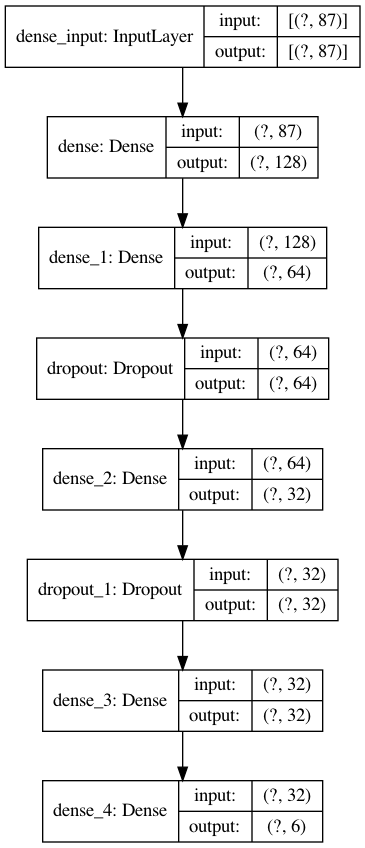

In [18]:
plot_model(nn, show_layer_names=True, show_shapes=True)

In [19]:
nn_preds = nn.predict(X_test_sc)

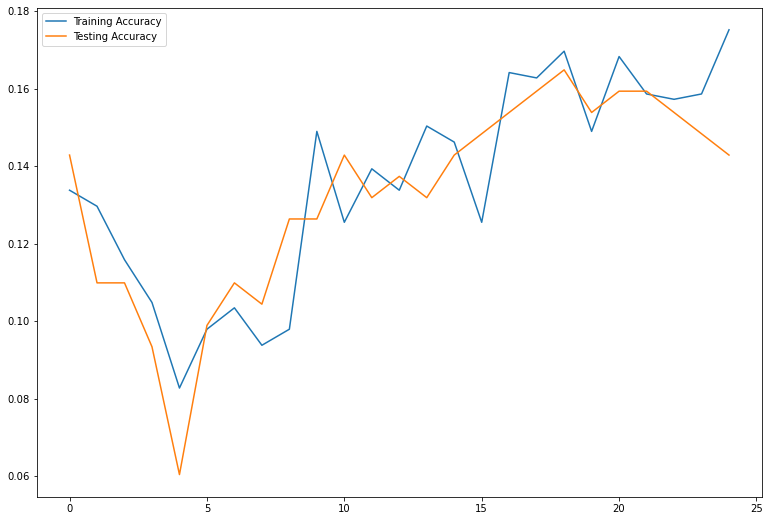

In [20]:
plt.figure(figsize=(13, 9))
plt.plot(hist.history['acc'], label = 'Training Accuracy')
plt.plot(hist.history['val_acc'], label = 'Testing Accuracy')
plt.legend();

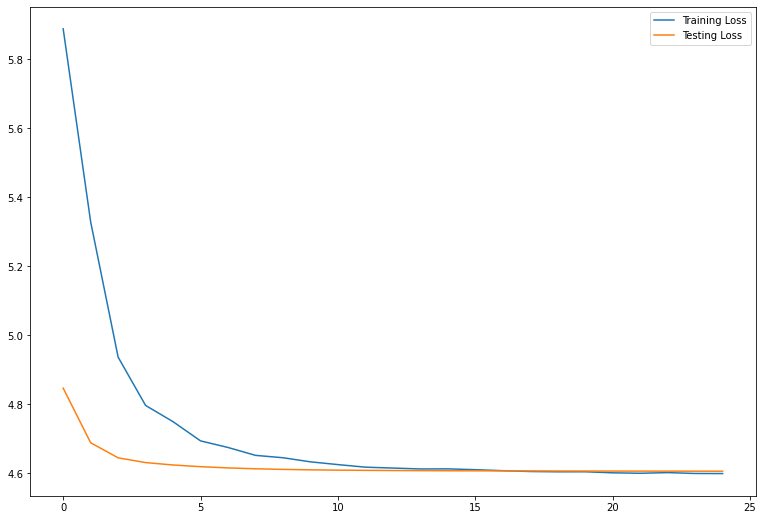

In [21]:
plt.figure(figsize=(13, 9))
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Testing Loss')
plt.legend();